<a href="https://colab.research.google.com/github/abdellah-idris/NLI/blob/master/Hierarchical_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **1. Importation des librairies**

In [ ]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score

### **2. Lecture des données**

In [ ]:
from google.colab import files

uploaded = files.upload()


Saving train.txt to train.txt


In [ ]:
os.listdir('.')

['.config', 'train.txt', 'sample_data']

In [ ]:
df = pd.read_csv('train.txt', sep='\t', header=None)

In [ ]:
def extract_country_and_text(row):
    match = re.match(r'\((.*?)\)(.*)', row)
    if match:
        country_code = match.group(1)
        text = match.group(2)
        return pd.Series([country_code, text])
    else:
        return pd.Series(['', row])

df[['country_code', 'text']] = df.iloc[:, 0].apply(extract_country_and_text)

df['country_code'].value_counts()

df

,0,country_code,text
0,(GER) IThe importance and popularity of travel...,GER,IThe importance and popularity of travelling ...
1,"(TUR) It is an important decision , how to pla...",TUR,"It is an important decision , how to plan you..."
2,(CHI) Some people believe that young people ca...,CHI,Some people believe that young people can enj...
3,(TEL) Travelling is usually considered as good...,TEL,Travelling is usually considered as good recr...
4,(ARA) i agree that . Life is a person live per...,ARA,i agree that . Life is a person live period o...
...,...,...,...
9895,"(CHI) Nowadays , more and more people go abroa...",CHI,"Nowadays , more and more people go abroad , n..."
9896,(KOR) In accomplishing something that is risky...,KOR,In accomplishing something that is risky come...
9897,"(SPA) At the beginning of the 21st century , t...",SPA,"At the beginning of the 21st century , the in..."
9898,(HIN) The number of cars in use across the wor...,HIN,The number of cars in use across the world ha...


In [ ]:
df.dropna(subset=['country_code'], inplace=True)
df.shape

# All texts are labeled

(9900, 3)

#### Fonctions d'évaluations et matrice de confusion :

In [ ]:
def evaluate_model_performance(model, model_name, method_name, train, test, y_train, y_test):

    model.fit(train, y_train)
    predictions = model.predict(test)

    # Calculating the performance metrics
    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions, average='macro')
    recall = recall_score(y_test, predictions, average='macro')
    f1 = f1_score(y_test, predictions, average='macro')

    # Printing the metrics
    print(f"{model_name} ({method_name}) \n- Accuracy: {accuracy:.4f} \n- Precision-macro: {precision:.4f} \n- Recall-macro: {recall:.4f} \n- F1-macro: {f1:.4f}")
    return model


In [ ]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

def evaluate_model_performance_detailed(mapping_list, model, model_name, method_name, train, test, y_train, y_test):
    model.fit(train, y_train)
    predictions = model.predict(test)

    # Metrics for each label
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, predictions, average=None)
    metrics_df = pd.DataFrame({'Label': list(mapping_list.keys()),
                               'Precision': precision,
                               'Recall': recall,
                               'F1 Score': f1})

    # Global (macro) metrics
    precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(y_test, predictions, average='macro')
    accuracy = accuracy_score(y_test, predictions)

    print(f"{model_name} ({method_name}) - Overall Metrics:\n- Accuracy: {accuracy:.4f}\n- Precision (Macro): {precision_macro:.4f}\n- Recall (Macro): {recall_macro:.4f}\n- F1 (Macro): {f1_macro:.4f}\n")

    print(f"{model_name} ({method_name}) - Metrics by Label:")
    print(metrics_df.to_string(index=False))
    return model


In [ ]:
def display_confusion_matrix(mapping_list, model, model_name, method_name, test, y_test):

    predictions = model.predict(test)
    cm = confusion_matrix(y_test, predictions)

    # Plotting the confusion matrix
    plt.figure(figsize=(5, 3))
    sns.heatmap(cm, annot=True, cmap='coolwarm', fmt='d', xticklabels=list(mapping_list.keys()), yticklabels=list(mapping_list.keys()))
    plt.title(f"Confusion Matrix - {model_name} ({method_name})")
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

#### Fonction équilibrage dataframe:

In [ ]:
def balance_dataframe_by_column(df, column_name, random_state=42):

    # Calculer le nombre d'échantillons pour chaque label
    label_counts = df[column_name].value_counts()

    # Trouver le nombre minimal d'échantillons parmi tous les labels
    min_samples = label_counts.min()


    # Créer un nouveau DataFrame équilibré
    df_balanced = pd.DataFrame()

    for label in df[column_name].unique():
        df_filtered = df[df[column_name] == label].sample(n=min_samples, random_state=random_state)
        df_balanced = pd.concat([df_balanced, df_filtered])

    return df_balanced

In [ ]:
def balance_dataframe_by_column2(df, column_name, group_mapping, random_state=42):
    # Group the data frame by the column before sampling
    grouped_df = df.groupby(column_name)

    # Map the groups to new values as per the group_mapping
    df[column_name] = df[column_name].map(group_mapping)

    # Calculate the number of samples for each label in the updated groups
    label_counts = df[column_name].value_counts()

    # Find the minimal number of samples among all the labels
    min_samples = label_counts.min()

    # Create a new DataFrame balanced across the new groups
    df_balanced = pd.DataFrame()

    for label in df[column_name].unique():
        # Sample from the grouped data frame
        df_filtered = grouped_df.get_group(label).sample(n=min_samples, random_state=random_state)
        df_balanced = pd.concat([df_balanced, df_filtered])

    return df_balanced

## **3. Entrainement des modèles (SVM + Logestic Regression)**

In [ ]:
vectorizer_BOW = CountVectorizer(max_features = 10000, min_df = 0.1, stop_words='english')
vectorizer_TF_IDF = TfidfVectorizer(max_features = 10000, stop_words='english')

# Modèles de classification
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'SVM': SVC(kernel='rbf')
}

### **3.1 Version sans Hiérarchie**

========================= Logistic Regression =========================
Logistic Regression (BOW) - Overall Metrics:
- Accuracy: 0.3621
- Precision (Macro): 0.3624
- Recall (Macro): 0.3652
- F1 (Macro): 0.3610

Logistic Regression (BOW) - Metrics by Label:
Label  Precision   Recall  F1 Score
  GER   0.467456 0.459302  0.463343
  TUR   0.272189 0.273810  0.272997
  CHI   0.333333 0.331429  0.332378
  TEL   0.463918 0.502793  0.482574
  ARA   0.290323 0.370588  0.325581
  SPA   0.324503 0.250000  0.282421
  HIN   0.331522 0.346591  0.338889
  JPN   0.394286 0.370968  0.382271
  KOR   0.363057 0.283582  0.318436
  FRE   0.378882 0.316062  0.344633
  ITA   0.366812 0.512195  0.427481


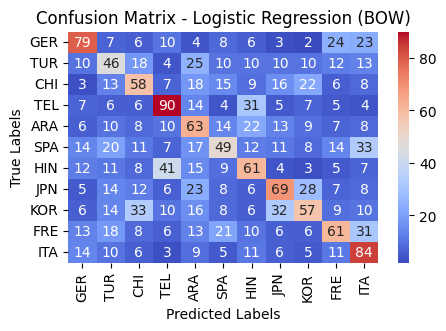

Logistic Regression (TF-IDF) - Overall Metrics:
- Accuracy: 0.6515
- Precision (Macro): 0.6520
- Recall (Macro): 0.6543
- F1 (Macro): 0.6509

Logistic Regression (TF-IDF) - Metrics by Label:
Label  Precision   Recall  F1 Score
  GER   0.722513 0.802326  0.760331
  TUR   0.565445 0.642857  0.601671
  CHI   0.652174 0.685714  0.668524
  TEL   0.645833 0.692737  0.668464
  ARA   0.625000 0.558824  0.590062
  SPA   0.658537 0.551020  0.600000
  HIN   0.577889 0.653409  0.613333
  JPN   0.697802 0.682796  0.690217
  KOR   0.658385 0.527363  0.585635
  FRE   0.712707 0.668394  0.689840
  ITA   0.655738 0.731707  0.691643


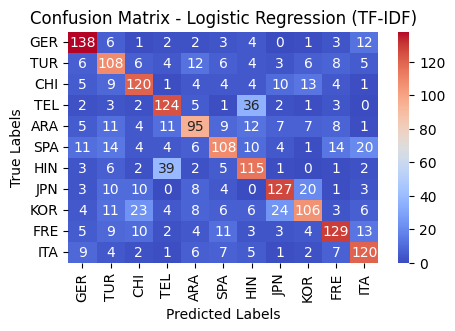

========================= SVM =========================
SVM (BOW) - Overall Metrics:
- Accuracy: 0.3545
- Precision (Macro): 0.3560
- Recall (Macro): 0.3571
- F1 (Macro): 0.3535

SVM (BOW) - Metrics by Label:
Label  Precision   Recall  F1 Score
  GER   0.432584 0.447674  0.440000
  TUR   0.295597 0.279762  0.287462
  CHI   0.280193 0.331429  0.303665
  TEL   0.426471 0.486034  0.454308
  ARA   0.302439 0.364706  0.330667
  SPA   0.347305 0.295918  0.319559
  HIN   0.345550 0.375000  0.359673
  JPN   0.395480 0.376344  0.385675
  KOR   0.350649 0.268657  0.304225
  FRE   0.396947 0.269430  0.320988
  ITA   0.342995 0.432927  0.382749


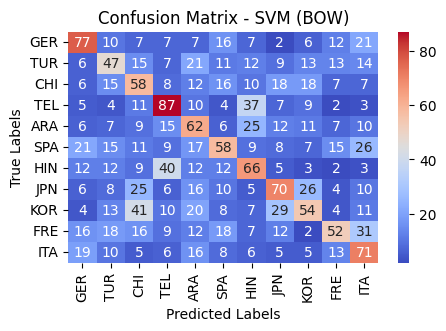

SVM (TF-IDF) - Overall Metrics:
- Accuracy: 0.6283
- Precision (Macro): 0.6331
- Recall (Macro): 0.6309
- F1 (Macro): 0.6289

SVM (TF-IDF) - Metrics by Label:
Label  Precision   Recall  F1 Score
  GER   0.694444 0.726744  0.710227
  TUR   0.523364 0.666667  0.586387
  CHI   0.586735 0.657143  0.619946
  TEL   0.682927 0.625698  0.653061
  ARA   0.615894 0.547059  0.579439
  SPA   0.656442 0.545918  0.596100
  HIN   0.543779 0.670455  0.600509
  JPN   0.695122 0.612903  0.651429
  KOR   0.614943 0.532338  0.570667
  FRE   0.706215 0.647668  0.675676
  ITA   0.644444 0.707317  0.674419


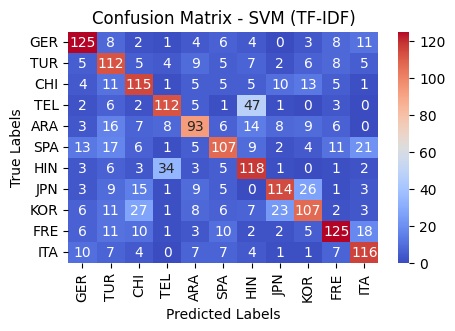

In [ ]:
mapping_list = {'GER' :0, 'TUR':1, 'CHI':2, 'TEL': 3, 'ARA' : 4, 'SPA' :5, 'HIN':6, 'JPN': 7, 'KOR':8, 'FRE':9, 'ITA':10}

X = df['text']
y = df['country_code'].map(mapping_list)

# Split data
train_bow, test_bow, y_train, y_test = train_test_split(vectorizer_BOW.fit_transform(X), y, test_size = 0.2, random_state = 42)
train_tf_idf , test_tf_idf , y_train, y_test = train_test_split(vectorizer_TF_IDF.fit_transform(X), y, test_size = 0.2, random_state = 42)

# Entraînement et évaluation des modèles
for model_name, model in models.items():
    print('========================= {} ========================='.format(model_name))

    # ***************** Entraînement avec BOW ******************
    evaluate_model_performance_detailed(mapping_list, model, model_name, "BOW", train_bow, test_bow, y_train, y_test)
    display_confusion_matrix(mapping_list, model, model_name, "BOW", test_bow, y_test)

    # **************** Entraînement avec TF-IDF ****************
    evaluate_model_performance_detailed(mapping_list, model, model_name, "TF-IDF", train_tf_idf, test_tf_idf, y_train, y_test)
    display_confusion_matrix(mapping_list, model, model_name, "TF-IDF", test_tf_idf, y_test)

**Analyse des résultats obtenus :**

Les modèles basés sur la méthode de préprocessing TF-IDF semblent mieux performants.

- Logistic Regression: (Accuracy: 65.15%).
- SVM : (Accuracy: 62.83%).

On choisit donc de garder uniquement la méthode TF-IDF pour la suite.

### **3.2 Model Hiérarchique**

En analysant les matrices de confusion précédentes, on remarque que le modèle confond certaines langues maternelles.

Pour réduire cette confusion, on essaye de de regrouper les catégories qui présentent des similarités en veillant à bien **équilibrer la taille des échantillons**.


In [ ]:
vectorizer_BOW = CountVectorizer(max_features = 10000, min_df = 0.1, stop_words='english')
vectorizer_TF_IDF = TfidfVectorizer(max_features = 10000, stop_words='english')

# Modèles de classification
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'SVM': SVC(kernel='rbf')
}

####  **Premier regroupement**:

TEL, HIN


========================= LogisticRegression =========================
LogisticRegression (TF-IDF) - Overall Metrics:
- Accuracy: 0.6572
- Precision (Macro): 0.6597
- Recall (Macro): 0.6585
- F1 (Macro): 0.6554

LogisticRegression (TF-IDF) - Metrics by Label:
  Label  Precision   Recall  F1 Score
    GER   0.752632 0.777174  0.764706
    TUR   0.670213 0.652850  0.661417
    CHI   0.500000 0.624204  0.555241
    ARA   0.695946 0.562842  0.622356
    SPA   0.586592 0.600000  0.593220
    JPN   0.651515 0.697297  0.673629
    KOR   0.625000 0.526316  0.571429
    FRE   0.683544 0.593407  0.635294
    ITA   0.778443 0.706522  0.740741
HIN+TEL   0.652778 0.844311  0.736292


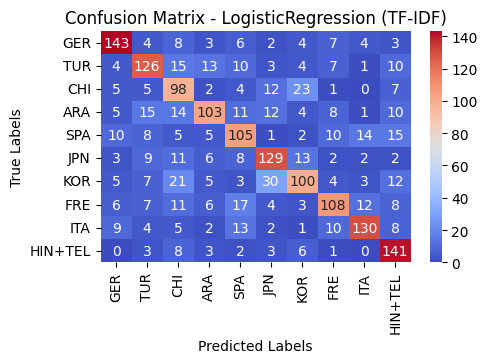

========================= SVM =========================
SVM (TF-IDF) - Overall Metrics:
- Accuracy: 0.6539
- Precision (Macro): 0.6580
- Recall (Macro): 0.6557
- F1 (Macro): 0.6541

SVM (TF-IDF) - Metrics by Label:
  Label  Precision   Recall  F1 Score
    GER   0.758065 0.766304  0.762162
    TUR   0.625000 0.647668  0.636132
    CHI   0.476190 0.636943  0.544959
    ARA   0.658228 0.568306  0.609971
    SPA   0.601036 0.662857  0.630435
    JPN   0.694915 0.664865  0.679558
    KOR   0.589286 0.521053  0.553073
    FRE   0.652439 0.587912  0.618497
    ITA   0.772152 0.663043  0.713450
HIN+TEL   0.752688 0.838323  0.793201


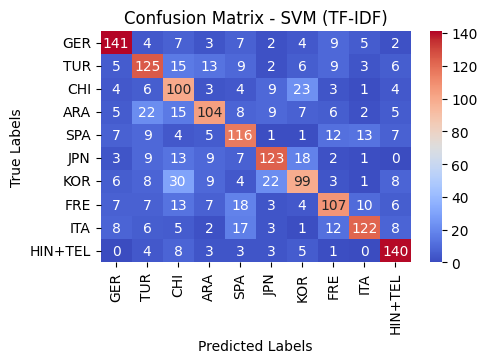

In [ ]:
# Créez une nouvelle colonne 'Country_Code_New1' en copiant 'Country_Code'
df['country_code_new1'] = df['country_code']

df.loc[df['country_code'].isin(['TEL', 'HIN']), 'country_code_new1']  = 'HIN+TEL'

new_mapping_list1 = {'GER':0, 'TUR':1, 'CHI':2, 'ARA':3, 'SPA':4, 'JPN':5, 'KOR':6, 'FRE':7, 'ITA':8, 'HIN+TEL':9}

# Equilibrage des échantillons
df_balanced1 = balance_dataframe_by_column(df, 'country_code_new1', random_state=42)

X = df_balanced1['text']
y_grouped1 = df_balanced1['country_code_new1'].map(new_mapping_list1)

# Split data avec y_grouped1
train_bow, test_bow, y_train_grouped1, y_test_grouped1 = train_test_split(vectorizer_BOW.fit_transform(X), y_grouped1, test_size=0.2, random_state=42)
train_tf_idf, test_tf_idf, y_train_grouped1, y_test_grouped1 = train_test_split(vectorizer_TF_IDF.fit_transform(X), y_grouped1, test_size=0.2, random_state=42)

group1_models = {}

# Entraînement et évaluation des modèles
for model_name, model in models.items():
    print('========================= {} ========================='.format(model_name))

    # ***************** Entraînement avec BOW ******************
    # evaluate_model_performance_detailed(new_mapping_list1, model, model_name, "BOW", train_bow, test_bow, y_train_grouped1, y_test_grouped1)
    # display_confusion_matrix(new_mapping_list1, model, model_name, "BOW", test_bow, y_test_grouped1)

    # **************** Entraînement avec TF-IDF ****************
    model_save = evaluate_model_performance_detailed(new_mapping_list1, model, model_name, "TF-IDF", train_tf_idf, test_tf_idf, y_train_grouped1, y_test_grouped1)
    display_confusion_matrix(new_mapping_list1, model, model_name, "TF-IDF", test_tf_idf, y_test_grouped1)
    group1_models[model_name+'_TF-IDF'] = model_save

####  **Second regroupement**:

- **Groupe 01**: TEL, HIN
- **Groupe 02**: KOR, CHI, JPN

========================= LogisticRegression =========================
LogisticRegression (TF-IDF) - Overall Metrics:
- Accuracy: 0.6840
- Precision (Macro): 0.6825
- Recall (Macro): 0.6885
- F1 (Macro): 0.6812

LogisticRegression (TF-IDF) - Metrics by Label:
      Label  Precision   Recall  F1 Score
        GER   0.686916 0.798913  0.738693
        TUR   0.697143 0.622449  0.657682
        ARA   0.611429 0.597765  0.604520
        SPA   0.619403 0.451087  0.522013
        FRE   0.735632 0.643216  0.686327
        ITA   0.716867 0.743750  0.730061
    HIN+TEL   0.736842 0.838323  0.784314
KOR+CHI+JPN   0.655660 0.812865  0.725849


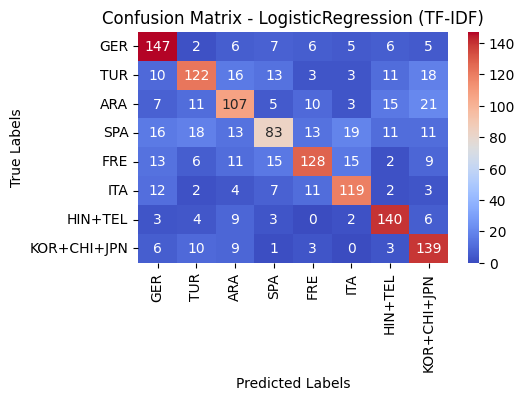

========================= SVM =========================
SVM (TF-IDF) - Overall Metrics:
- Accuracy: 0.6757
- Precision (Macro): 0.6756
- Recall (Macro): 0.6808
- F1 (Macro): 0.6753

SVM (TF-IDF) - Metrics by Label:
      Label  Precision   Recall  F1 Score
        GER   0.717172 0.771739  0.743455
        TUR   0.645503 0.622449  0.633766
        ARA   0.602273 0.592179  0.597183
        SPA   0.581699 0.483696  0.528190
        FRE   0.709091 0.587940  0.642857
        ITA   0.708333 0.743750  0.725610
    HIN+TEL   0.796512 0.820359  0.808260
KOR+CHI+JPN   0.643836 0.824561  0.723077


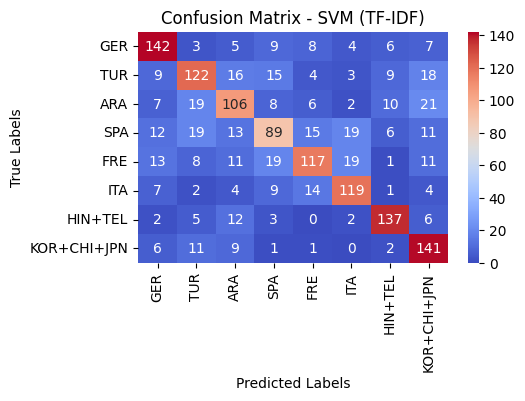

In [ ]:
# Créez une nouvelle colonne 'Country_Code_New2' en copiant 'Country_Code'
df['country_code_new2'] = df['country_code']

df.loc[df['country_code'].isin(['TEL', 'HIN']), 'country_code_new2']  = 'HIN+TEL'
df.loc[df['country_code'].isin(['KOR', 'CHI','JPN']), 'country_code_new2'] = 'KOR+CHI+JPN'

new_mapping_list2 = {'GER':0, 'TUR':1, 'ARA':2, 'SPA':3, 'FRE':4, 'ITA':5, 'HIN+TEL':6, 'KOR+CHI+JPN':7}

df_balanced2 = balance_dataframe_by_column(df, 'country_code_new2', random_state=42)

X = df_balanced2['text']
y_grouped2 = df_balanced2['country_code_new2'].map(new_mapping_list2)

# Split data avec y_grouped2
train_bow, test_bow, y_train_grouped2, y_test_grouped2 = train_test_split(vectorizer_BOW.fit_transform(X), y_grouped2, test_size=0.2, random_state=42)
train_tf_idf, test_tf_idf, y_train_grouped2, y_test_grouped2 = train_test_split(vectorizer_TF_IDF.fit_transform(X), y_grouped2, test_size=0.2, random_state=42)

# save models
group2_models = {}

# Entraînement et évaluation des modèles
for model_name, model in models.items():
    print('========================= {} ========================='.format(model_name))

    # ***************** Entraînement avec BOW ******************
    #evaluate_model_performance_detailed(new_mapping_list2, model, model_name, "BOW", train_bow, test_bow, y_train_grouped2, y_test_grouped2)
    #display_confusion_matrix(new_mapping_list2, model, model_name, "BOW", test_bow, y_test_grouped2)

    # **************** Entraînement avec TF-IDF ****************
    model_save = evaluate_model_performance_detailed(new_mapping_list2, model, model_name, "TF-IDF", train_tf_idf, test_tf_idf, y_train_grouped2, y_test_grouped2)
    display_confusion_matrix(new_mapping_list2, model, model_name, "TF-IDF", test_tf_idf, y_test_grouped2)
    group2_models[model_name+'_TF-IDF'] = model_save


####  **Troisème regroupement**:
- **Groupe 01**: TEL, HIN
- **Groupe 02**: KOR, CHI, JPN
- **Groupe 03**: FRE, SPA, ITA, GER
- ARA
- TUR

========================= LogisticRegression =========================
LogisticRegression (BOW) - Overall Metrics:
- Accuracy: 0.5278
- Precision (Macro): 0.5287
- Recall (Macro): 0.5300
- F1 (Macro): 0.5275

LogisticRegression (BOW) - Metrics by Label:
          Label  Precision   Recall  F1 Score
            TUR   0.459459 0.474860  0.467033
            ARA   0.493976 0.438503  0.464589
        HIN+TEL   0.564972 0.584795  0.574713
    KOR+CHI+JPN   0.531401 0.635838  0.578947
FRE+SPA+ITA+GER   0.593939 0.515789  0.552113


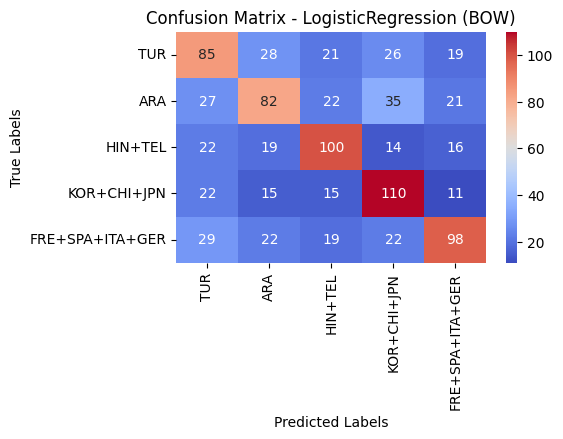

LogisticRegression (TF-IDF) - Overall Metrics:
- Accuracy: 0.7156
- Precision (Macro): 0.7151
- Recall (Macro): 0.7181
- F1 (Macro): 0.7152

LogisticRegression (TF-IDF) - Metrics by Label:
          Label  Precision   Recall  F1 Score
            TUR   0.704545 0.692737  0.698592
            ARA   0.686747 0.609626  0.645892
        HIN+TEL   0.744681 0.818713  0.779944
    KOR+CHI+JPN   0.697917 0.774566  0.734247
FRE+SPA+ITA+GER   0.741573 0.694737  0.717391


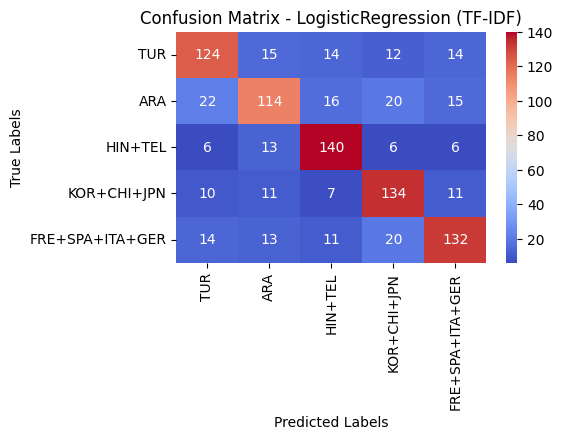

========================= SVM =========================
SVM (BOW) - Overall Metrics:
- Accuracy: 0.5022
- Precision (Macro): 0.5019
- Recall (Macro): 0.5050
- F1 (Macro): 0.5009

SVM (BOW) - Metrics by Label:
          Label  Precision   Recall  F1 Score
            TUR   0.454545 0.446927  0.450704
            ARA   0.493421 0.401070  0.442478
        HIN+TEL   0.561404 0.561404  0.561404
    KOR+CHI+JPN   0.513761 0.647399  0.572890
FRE+SPA+ITA+GER   0.486339 0.468421  0.477212


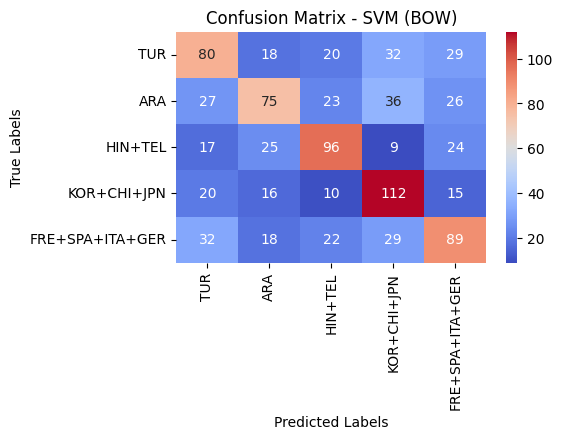

SVM (TF-IDF) - Overall Metrics:
- Accuracy: 0.7156
- Precision (Macro): 0.7163
- Recall (Macro): 0.7177
- F1 (Macro): 0.7160

SVM (TF-IDF) - Metrics by Label:
          Label  Precision   Recall  F1 Score
            TUR   0.684783 0.703911  0.694215
            ARA   0.693252 0.604278  0.645714
        HIN+TEL   0.796512 0.801170  0.798834
    KOR+CHI+JPN   0.696335 0.768786  0.730769
FRE+SPA+ITA+GER   0.710526 0.710526  0.710526


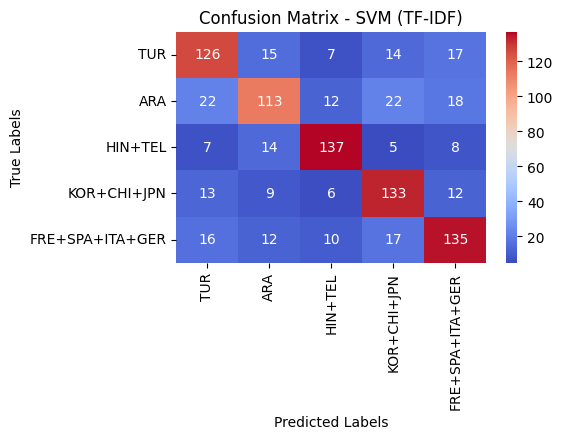

In [ ]:
# Créez une nouvelle colonne 'Country_Code_New3' en copiant 'Country_Code'
df['country_code_new3'] = df['country_code']

df.loc[df['country_code'].isin(['TEL', 'HIN']), 'country_code_new3']  = 'HIN+TEL'
df.loc[df['country_code'].isin(['KOR', 'CHI','JPN']), 'country_code_new3'] = 'KOR+CHI+JPN'
df.loc[df['country_code'].isin(['FRE', 'SPA','ITA','GER']), 'country_code_new3'] = 'FRE+SPA+ITA+GER'

new_mapping_list3 = {'TUR':0, 'ARA':1, 'HIN+TEL':2, 'KOR+CHI+JPN':3, 'FRE+SPA+ITA+GER':4}

df_balanced3 = balance_dataframe_by_column(df, 'country_code_new3', random_state=42)

X = df_balanced3['text']
y_grouped3 = df_balanced3['country_code_new3'].map(new_mapping_list3)

# Split data avec y_grouped3
train_bow, test_bow, y_train_grouped3_bow, y_test_grouped3_bow = train_test_split(vectorizer_BOW.fit_transform(X), y_grouped3, test_size=0.2, random_state=42)
train_tf_idf, test_tf_idf, y_train_grouped3, y_test_grouped3 = train_test_split(vectorizer_TF_IDF.fit_transform(X), y_grouped3, test_size=0.2, random_state=42)

group3_models = {}
# Entraînement et évaluation des modèles
for model_name, model in models.items():
    print('========================= {} ========================='.format(model_name))

    # ***************** Entraînement avec BOW ******************
    model_save = evaluate_model_performance_detailed(new_mapping_list3, model, model_name, "BOW", train_bow, test_bow, y_train_grouped3_bow, y_test_grouped3_bow)
    display_confusion_matrix(new_mapping_list3, model, model_name, "BOW", test_bow, y_test_grouped3_bow)
    group3_models[model_name+'_BOW']  = model_save

    # **************** Entraînement avec TF-IDF ****************
    model_save = evaluate_model_performance_detailed(new_mapping_list3, model, model_name, "TF-IDF", train_tf_idf, test_tf_idf, y_train_grouped3, y_test_grouped3)
    display_confusion_matrix(new_mapping_list3, model, model_name, "TF-IDF", test_tf_idf, y_test_grouped3)
    group3_models[model_name+'_TF-IDF']  = model_save

####  **Quatrième regroupement**:

On essaye de regrouper "ARA" et "TUR":

  - **Groupe 01**: TEL, HIN
  - **Groupe 02**: KOR, CHI, JPN
  - **Groupe 03**: FRE, SPA, ITA, GER
  - **Groupe 04**: ARA, TUR

========================= LogisticRegression =========================
LogisticRegression (BOW) - Overall Metrics:
- Accuracy: 0.6076
- Precision (Macro): 0.6055
- Recall (Macro): 0.6055
- F1 (Macro): 0.6047

LogisticRegression (BOW) - Metrics by Label:
          Label  Precision   Recall  F1 Score
        HIN+TEL   0.678100 0.715877  0.696477
    KOR+CHI+JPN   0.601036 0.639118  0.619493
FRE+SPA+ITA+GER   0.675516 0.602632  0.636996
        ARA+TUR   0.467262 0.464497  0.465875


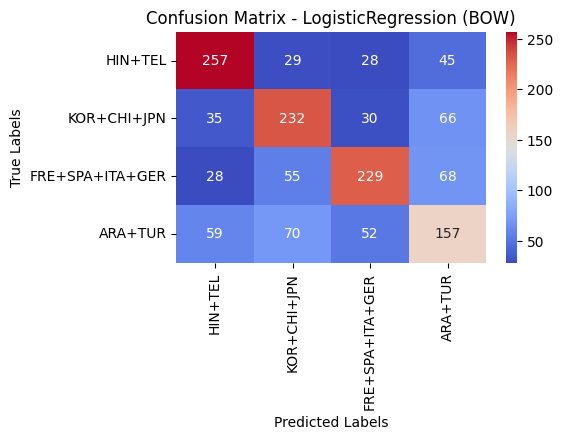

LogisticRegression (TF-IDF) - Overall Metrics:
- Accuracy: 0.8215
- Precision (Macro): 0.8209
- Recall (Macro): 0.8210
- F1 (Macro): 0.8206

LogisticRegression (TF-IDF) - Metrics by Label:
          Label  Precision   Recall  F1 Score
        HIN+TEL   0.877778 0.880223  0.878999
    KOR+CHI+JPN   0.802597 0.851240  0.826203
FRE+SPA+ITA+GER   0.833795 0.792105  0.812416
        ARA+TUR   0.769461 0.760355  0.764881


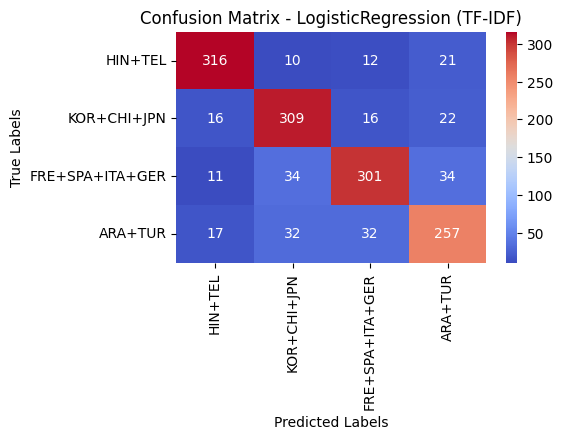

========================= SVM =========================
SVM (BOW) - Overall Metrics:
- Accuracy: 0.5979
- Precision (Macro): 0.5938
- Recall (Macro): 0.5959
- F1 (Macro): 0.5939

SVM (BOW) - Metrics by Label:
          Label  Precision   Recall  F1 Score
        HIN+TEL   0.671958 0.707521  0.689281
    KOR+CHI+JPN   0.621212 0.677686  0.648221
FRE+SPA+ITA+GER   0.632047 0.560526  0.594142
        ARA+TUR   0.449848 0.437870  0.443778


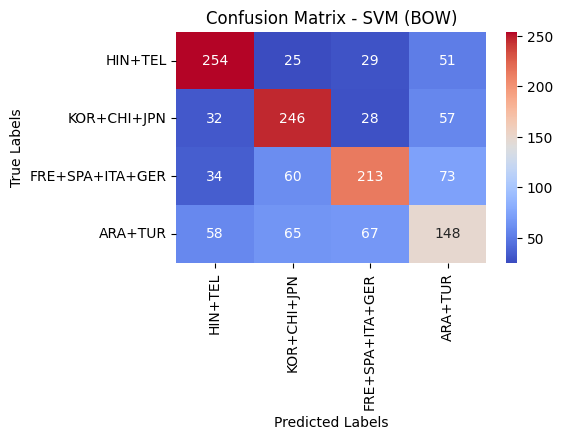

SVM (TF-IDF) - Overall Metrics:
- Accuracy: 0.8104
- Precision (Macro): 0.8115
- Recall (Macro): 0.8102
- F1 (Macro): 0.8103

SVM (TF-IDF) - Metrics by Label:
          Label  Precision   Recall  F1 Score
        HIN+TEL   0.900875 0.860724  0.880342
    KOR+CHI+JPN   0.801587 0.834711  0.817814
FRE+SPA+ITA+GER   0.819945 0.778947  0.798920
        ARA+TUR   0.723464 0.766272  0.744253


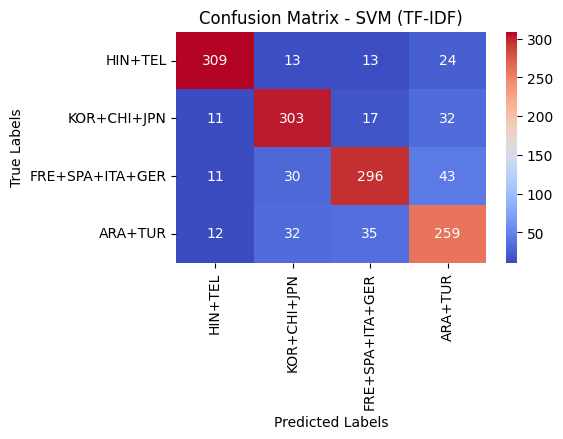

In [ ]:
# Créez une nouvelle colonne 'Country_Code_New4' en copiant 'Country_Code'
df['country_code_new4'] = df['country_code']

df.loc[df['country_code'].isin(['TEL', 'HIN']), 'country_code_new4']  = 'HIN+TEL'
df.loc[df['country_code'].isin(['KOR', 'CHI','JPN']), 'country_code_new4'] = 'KOR+CHI+JPN'
df.loc[df['country_code'].isin(['FRE', 'SPA','ITA','GER']), 'country_code_new4'] = 'FRE+SPA+ITA+GER'
df.loc[df['country_code'].isin(['ARA', 'TUR']), 'country_code_new4'] = 'ARA+TUR'

new_mapping_list4 = {'HIN+TEL':0, 'KOR+CHI+JPN':1, 'FRE+SPA+ITA+GER':2,'ARA+TUR':3}

df_balanced4 = balance_dataframe_by_column(df, 'country_code_new4', random_state=42)

X = df_balanced4['text']
y_grouped4 = df_balanced4['country_code_new4'].map(new_mapping_list4)

# Split data avec y_grouped4
train_bow, test_bow, y_train_grouped4, y_test_grouped4 = train_test_split(vectorizer_BOW.fit_transform(X), y_grouped4, test_size=0.2, random_state=42)
train_tf_idf, test_tf_idf, y_train_grouped4, y_test_grouped4 = train_test_split(vectorizer_TF_IDF.fit_transform(X), y_grouped4, test_size=0.2, random_state=42)

group4_models = {}

# Entraînement et évaluation des modèles
for model_name, model in models.items():
    print('========================= {} ========================='.format(model_name))

    # ***************** Entraînement avec BOW ******************
    model_save = evaluate_model_performance_detailed(new_mapping_list4, model, model_name, "BOW", train_bow, test_bow, y_train_grouped4, y_test_grouped4)
    display_confusion_matrix(new_mapping_list4, model, model_name, "BOW", test_bow, y_test_grouped4)
    group4_models[model_name+'_BOW'] = model_save
    # **************** Entraînement avec TF-IDF ****************
    model_save = evaluate_model_performance_detailed(new_mapping_list4, model, model_name, "TF-IDF", train_tf_idf, test_tf_idf, y_train_grouped4, y_test_grouped4)
    display_confusion_matrix(new_mapping_list4, model, model_name, "TF-IDF", test_tf_idf, y_test_grouped4)
    group4_models[model_name+'_TF-IDF']  = model_save


####  **Cinquième regroupement**:
- **Groupe 01**: TEL, HIN
- **Groupe 02**: KOR, CHI, JPN
- **Groupe 03**: FRE, SPA, ITA
- TUR
- ARA
- GER


========================= LogisticRegression =========================
LogisticRegression (TF-IDF) - Overall Metrics:
- Accuracy: 0.7463
- Precision (Macro): 0.7449
- Recall (Macro): 0.7465
- F1 (Macro): 0.7429

LogisticRegression (TF-IDF) - Metrics by Label:
      Label  Precision   Recall  F1 Score
        TUR   0.812121 0.697917  0.750700
        ARA   0.675159 0.602273  0.636637
    HIN+TEL   0.775000 0.890805  0.828877
KOR+CHI+JPN   0.678392 0.808383  0.737705
FRE+SPA+ITA   0.696429 0.676301  0.686217
        GER   0.832461 0.803030  0.817481


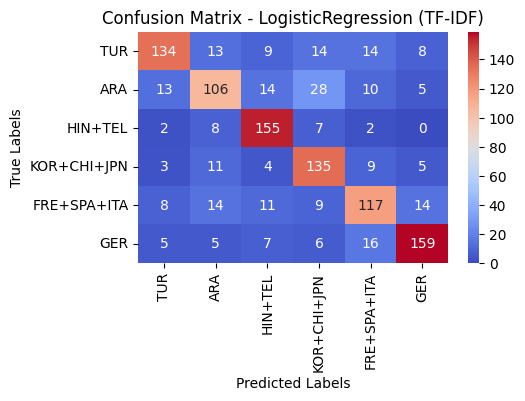

========================= SVM =========================
SVM (TF-IDF) - Overall Metrics:
- Accuracy: 0.7407
- Precision (Macro): 0.7404
- Recall (Macro): 0.7419
- F1 (Macro): 0.7389

SVM (TF-IDF) - Metrics by Label:
      Label  Precision   Recall  F1 Score
        TUR   0.738889 0.692708  0.715054
        ARA   0.677215 0.607955  0.640719
    HIN+TEL   0.805263 0.879310  0.840659
KOR+CHI+JPN   0.678392 0.808383  0.737705
FRE+SPA+ITA   0.685393 0.705202  0.695157
        GER   0.857143 0.757576  0.804290


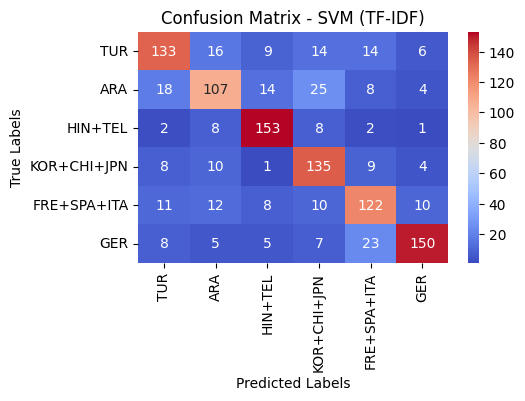

In [ ]:
# Créez une nouvelle colonne 'Country_Code_New5' en copiant 'Country_Code'
df['country_code_new5'] = df['country_code']

df.loc[df['country_code'].isin(['TEL', 'HIN']), 'country_code_new5']  = 'HIN+TEL'
df.loc[df['country_code'].isin(['KOR', 'CHI','JPN']), 'country_code_new5'] = 'KOR+CHI+JPN'
df.loc[df['country_code'].isin(['FRE', 'SPA','ITA']), 'country_code_new5'] = 'FRE+SPA+ITA'

new_mapping_list5 = {'TUR':0, 'ARA':1, 'HIN+TEL':2, 'KOR+CHI+JPN':3, 'FRE+SPA+ITA':4, 'GER':5}

df_balanced5 = balance_dataframe_by_column(df, 'country_code_new5', random_state=42)

X = df_balanced5['text']
y_grouped5 = df_balanced5['country_code_new5'].map(new_mapping_list5)

# Split data avec y_grouped5
train_bow, test_bow, y_train_grouped5, y_test_grouped5 = train_test_split(vectorizer_BOW.fit_transform(X), y_grouped5, test_size=0.2, random_state=42)
train_tf_idf, test_tf_idf, y_train_grouped5, y_test_grouped5 = train_test_split(vectorizer_TF_IDF.fit_transform(X), y_grouped5, test_size=0.2, random_state=42)


group5_models = {}

# Entraînement et évaluation des modèles
for model_name, model in models.items():
    print('========================= {} ========================='.format(model_name))

    # ***************** Entraînement avec BOW ******************
    #evaluate_model_performance_detailed(new_mapping_list5, model, model_name, "BOW", train_bow, test_bow, y_train_grouped5, y_test_grouped5)
    #display_confusion_matrix(new_mapping_list5, model, model_name, "BOW", test_bow, y_test_grouped5)

    # **************** Entraînement avec TF-IDF ****************
    model_save = evaluate_model_performance_detailed(new_mapping_list5, model, model_name, "TF-IDF", train_tf_idf, test_tf_idf, y_train_grouped5, y_test_grouped5)
    display_confusion_matrix(new_mapping_list5, model, model_name, "TF-IDF", test_tf_idf, y_test_grouped5)
    group5_models[model_name+'_TF-IDF']  = model_save


####  **Sixième regroupement**:

  - **Groupe 01**: TEL, HIN
  - **Groupe 02**: KOR, CHI, JPN
  - **Groupe 03**: FRE, SPA, ITA
  - **Groupe 04**: ARA, TUR
  - GER

========================= LogisticRegression =========================
LogisticRegression (TF-IDF) - Overall Metrics:
- Accuracy: 0.7400
- Precision (Macro): 0.7387
- Recall (Macro): 0.7413
- F1 (Macro): 0.7381

LogisticRegression (TF-IDF) - Metrics by Label:
      Label  Precision   Recall  F1 Score
    HIN+TEL   0.827586 0.842105  0.834783
KOR+CHI+JPN   0.699507 0.820809  0.755319
FRE+SPA+ITA   0.744048 0.668449  0.704225
    ARA+TUR   0.645570 0.569832  0.605341
        GER   0.776650 0.805263  0.790698


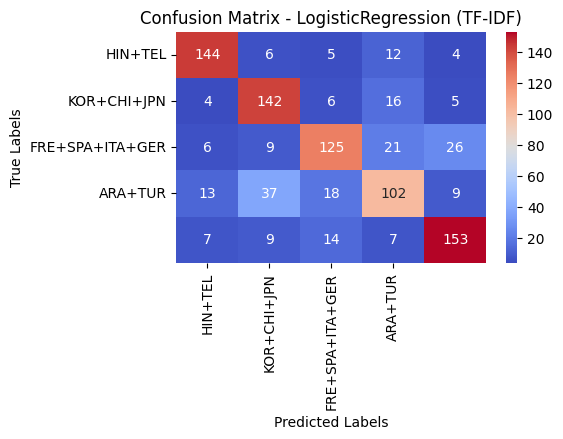

========================= SVM =========================
SVM (TF-IDF) - Overall Metrics:
- Accuracy: 0.7433
- Precision (Macro): 0.7453
- Recall (Macro): 0.7444
- F1 (Macro): 0.7439

SVM (TF-IDF) - Metrics by Label:
      Label  Precision   Recall  F1 Score
    HIN+TEL   0.854545 0.824561  0.839286
KOR+CHI+JPN   0.700508 0.797688  0.745946
FRE+SPA+ITA   0.739884 0.684492  0.711111
    ARA+TUR   0.629213 0.625698  0.627451
        GER   0.802139 0.789474  0.795756


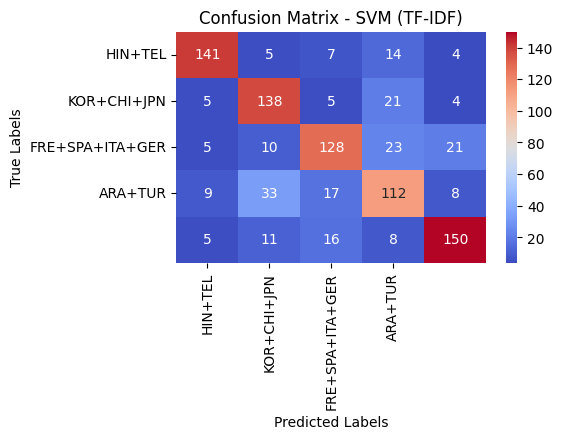

In [ ]:
# Créez une nouvelle colonne 'Country_Code_New6' en copiant 'Country_Code'
df['country_code_new6'] = df['country_code']

df.loc[df['country_code'].isin(['TEL', 'HIN']), 'country_code_new6']  = 'HIN+TEL'
df.loc[df['country_code'].isin(['KOR', 'CHI','JPN']), 'country_code_new6'] = 'KOR+CHI+JPN'
df.loc[df['country_code'].isin(['FRE', 'SPA','ITA']), 'country_code_new6'] = 'FRE+SPA+ITA'
df.loc[df['country_code'].isin(['ARA', 'TUR']), 'country_code_new6'] = 'ARA+TUR'

new_mapping_list6 = {'HIN+TEL':0, 'KOR+CHI+JPN':1, 'FRE+SPA+ITA':2,'ARA+TUR':3, 'GER':4}

df_balanced6 = balance_dataframe_by_column(df, 'country_code_new6', random_state=42)

X = df_balanced6['text']
y_grouped6 = df_balanced6['country_code_new6'].map(new_mapping_list6)

# Split data avec y_grouped6
train_bow, test_bow, y_train_grouped6, y_test_grouped6 = train_test_split(vectorizer_BOW.fit_transform(X), y_grouped6, test_size=0.2, random_state=42)
train_tf_idf, test_tf_idf, y_train_grouped6, y_test_grouped6 = train_test_split(vectorizer_TF_IDF.fit_transform(X), y_grouped6, test_size=0.2, random_state=42)

group6_models = {}

# Entraînement et évaluation des modèles
for model_name, model in models.items():
    print('========================= {} ========================='.format(model_name))

    # ***************** Entraînement avec BOW ******************
    #evaluate_model_performance_detailed(new_mapping_list6, model, model_name, "BOW", train_bow, test_bow, y_train_grouped6, y_test_grouped6)
    #display_confusion_matrix(new_mapping_list6, model, model_name, "BOW", test_bow, y_test_grouped6)

    # **************** Entraînement avec TF-IDF ****************
    model_save = evaluate_model_performance_detailed(new_mapping_list6, model, model_name, "TF-IDF", train_tf_idf, test_tf_idf, y_train_grouped6, y_test_grouped6)
    display_confusion_matrix(new_mapping_list4, model, model_name, "TF-IDF", test_tf_idf, y_test_grouped6)
    group6_models[model_name+'_TF-IDF']  = model_save
